In [1]:
import torch
from torch import nn, optim
from torch.functional import F
from torch.utils.data import dataloader, Dataset
from torchvision import transforms
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv

/Users/aronsajanphilip/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SelfDrivingDataset(Dataset):
    def __init__(self, training_data):
        super(SelfDrivingDataset, self).__init__()
        self.training_df = pd.read_csv(training_data)
        self.transform = transforms.Compose([transforms.Resize((320,160)), 
                                             transforms.ToTensor(), 
                                             transforms.Lambda(lambda x: (x/255.0)-0.5)])
        
    
    def __len__(self):
        return self.training_df.shape[0]
    
    def process_data(self, img_path, steering_radius):
        img_arr = np.asarray(Image.open(img_path))[65:-25, :, :]
        if(np.random.random()>=0.5):
            img_arr = cv.flip(img_arr, 1)
            steering_radius*=-1
        return self.transform(Image.fromarray(img_arr)),steering_radius
    
    def __getitem__(self, index):
        center_img_path = self.training_df.iloc[index][0].strip()
        left_img_path = self.training_df.iloc[index][1].strip()
        right_img_path = self.training_df.iloc[index][2].strip()
        steering_rad =  self.training_df.iloc[index][3]
        center_img_tensor, center_rad = self.process_data(center_img_path, steering_rad)
        left_img_tensor, left_rad = self.process_data(left_img_path, steering_rad+0.4)
        right_img_tensor, right_rad = self.process_data(right_img_path, steering_rad-0.4)
        return (left_img_tensor,left_rad), (center_img_tensor, center_rad), (right_img_tensor, right_rad)

In [3]:
driving_dataset = SelfDrivingDataset("./driving_log.csv")
driving_dataloader = dataloader.DataLoader(driving_dataset, shuffle=True, batch_size=10)

In [4]:
def render_image(img_tensor):
    img_arr = img_tensor.detach().numpy()
    img_arr = np.transpose(img_arr, (1,2,0))
    
    img_arr = (img_arr+0.5)*255
    return img_arr

In [5]:
%matplotlib inline
(left_img, left_steering_rads), (center_img, center_steering_rad), (right_img, right_steering_rad) = iter(driving_dataloader).next()
print(left_steering_rads)
print("----")
print(center_steering_rad)
print("----")
print(right_steering_rad)


tensor([-0.4000, -0.4000,  0.4000,  0.4000,  0.4000, -0.6613,  0.4000, -0.1325,
        -0.4000, -0.2386], dtype=torch.float64)
----
tensor([-0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.2613, -0.0000,  0.2675,
         0.0000, -0.1614], dtype=torch.float64)
----
tensor([ 0.4000,  0.4000,  0.4000,  0.4000, -0.4000, -0.1387,  0.4000,  0.6675,
         0.4000, -0.5614], dtype=torch.float64)


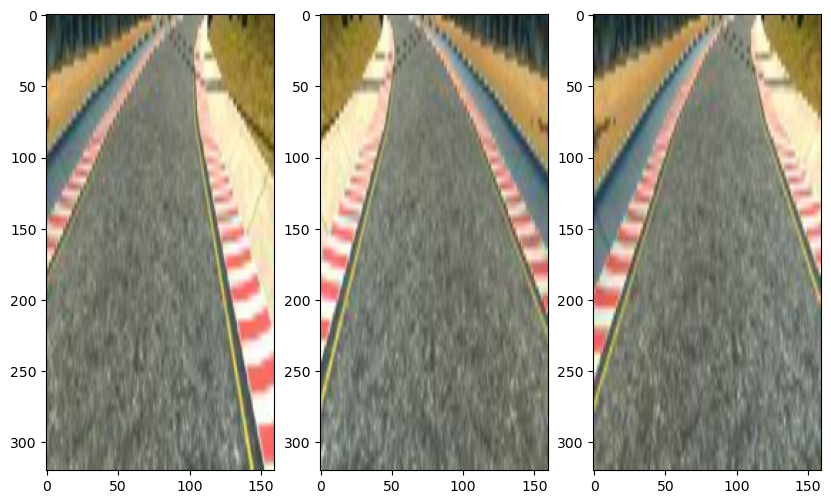

In [6]:
fig = plt.figure(figsize=(10,10))
idx = 8
images = [left_img[idx], center_img[idx], right_img[idx]]
for i in range(1,4):
    ax = fig.add_subplot(1,3, i)
    ax.imshow(render_image(images[i-1]))


In [7]:
a = iter(driving_dataloader).next()

In [8]:
device = torch.device("mps:0")

class SelfDrivingModel(nn.Module):
    
    def __init__(self):
        super(SelfDrivingModel, self).__init__()
        ##320x160
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=(3,3), stride=(2,2), device=device)  ## 159x79
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=(3,3), stride=(2,2), device=device) ## 79x39
        self.pool = nn.MaxPool2d(4,4) # 19x9
        self.fc1 = nn.Linear(in_features=48*19*9, out_features=50, device=device)
        self.fc2 = nn.Linear(in_features=50, out_features=10, device=device)
        self.fc3 = nn.Linear(in_features=10, out_features=1, device=device)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, img_tensor):
        x = F.elu(self.conv1(img_tensor))
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 48*19*9)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [9]:
net = SelfDrivingModel()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [10]:
max_epochs = 15

for epoch in range(0, max_epochs):
    total_loss = 0
    for data_batches in driving_dataloader:
        for img_batch, steering_rad_batch in data_batches:
            img_batch = img_batch.to(device=device)
            steering_rad_batch = steering_rad_batch.to(device=device, dtype=torch.float32)
            optimizer.zero_grad()
            predictions = net(img_batch).squeeze()
            loss = criterion(predictions, steering_rad_batch)
            total_loss+=loss.item()
            loss.backward()
            optimizer.step()
    print("Loss : {}".format(total_loss))


Loss : 77.03124593661579
Loss : 76.69834556581918
Loss : 77.08335032220748
Loss : 76.53457055014223
Loss : 76.26842423537164
Loss : 76.30742280773302
Loss : 76.40620080998997
Loss : 76.41909072768226
Loss : 76.27217460698739
Loss : 76.62634513704688
Loss : 76.25924750658623
Loss : 76.16822551286532
Loss : 76.16062512316421
Loss : 76.23053562395444
Loss : 76.31719098509564


In [11]:
net.state_dict()

/Users/aronsajanphilip/opt/anaconda3/envs/machine_learning/lib/python3.8/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484780698/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


OrderedDict([('conv1.weight',
              tensor([[[[-1.8153e-01, -9.8715e-03,  1.3582e-01],
                        [-7.7550e-02,  7.4831e-02,  1.0970e-01],
                        [ 1.7887e-02,  1.7766e-01,  1.6885e-01]],
              
                       [[-1.0995e-01, -2.0032e-02, -1.1223e-01],
                        [ 1.0723e-01,  9.4285e-02,  1.5260e-01],
                        [-3.7897e-02,  1.2848e-01, -7.2779e-02]],
              
                       [[-4.6420e-02,  6.7236e-02,  7.3965e-02],
                        [ 2.5466e-02,  1.5824e-02, -5.3321e-02],
                        [ 1.1308e-01, -3.7894e-02, -1.8461e-01]]],
              
              
                      [[[ 1.1055e-01, -1.5415e-01, -6.2845e-02],
                        [ 6.1919e-02, -1.5674e-01, -1.7651e-01],
                        [-1.7131e-03,  1.7644e-02, -9.4804e-02]],
              
                       [[ 1.3952e-01,  4.9315e-02,  1.8080e-01],
                        [-1.7494e-01,  5.5532

In [16]:
torch.save(net.state_dict(), "./self_driving.pt")

In [17]:
net.load_state_dict(torch.load("./self_driving.pt"))

<All keys matched successfully>

In [18]:
with torch.no_grad():
    net.eval()
    for _, (images, labels), _ in driving_dataloader:
        predictions = net(images.to(device)).cpu()
        print(predictions.squeeze().shape, labels.shape)
        print("correct --> {}".format(labels))
        print("predicted --> {}".format(predictions.squeeze()))

torch.Size([10]) torch.Size([10])
correct --> tensor([0.0762, 0.2909, 0.0000, 0.0000, 0.3864, -0.0000, 0.0843, -0.0000, 0.2035,
        0.0000], dtype=torch.float64)
predicted --> tensor([-0.0012, -0.0012, -0.0012, -0.0013, -0.0013, -0.0013, -0.0012, -0.0013,
        -0.0013, -0.0012])
torch.Size([10]) torch.Size([10])
correct --> tensor([-0.3757,  0.0000,  0.0292,  0.0000, -0.2138, -0.0000,  0.0000,  0.1078,
        -0.0000, -0.0000], dtype=torch.float64)
predicted --> tensor([-0.0012, -0.0013, -0.0012, -0.0013, -0.0012, -0.0012, -0.0013, -0.0012,
        -0.0013, -0.0012])
torch.Size([10]) torch.Size([10])
correct --> tensor([-0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.1552, -0.0000,
         0.0000,  0.0000], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0013, -0.0013, -0.0012, -0.0012, -0.0013, -0.0013, -0.0013,
        -0.0012, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([-0.0000, 0.0180, 0.5950, -0.0000, 0.0000, -0.0000, 0.6081, 0.0000, -0

torch.Size([10]) torch.Size([10])
correct --> tensor([ 0.0000, -0.0000,  0.0000, -0.0000,  0.0090, -0.1551,  0.0000, -0.0000,
         0.0000, -0.0507], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0012, -0.0012, -0.0012, -0.0012, -0.0012, -0.0012, -0.0013,
        -0.0013, -0.0012])
torch.Size([10]) torch.Size([10])
correct --> tensor([-0.4234,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.4551,
         0.0000, -0.0000], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0012, -0.0013, -0.0013, -0.0012, -0.0012, -0.0013, -0.0012,
        -0.0012, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([-0.0000, 0.1157, -0.0000, 0.0000, 0.3243, 0.1563, 0.0000, -0.0000, 0.0000,
        -0.0000], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0013, -0.0013, -0.0012, -0.0013, -0.0012, -0.0012, -0.0013,
        -0.0013, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([-0.0000,  0.0000, -0.2780, -0.0122, -0.3907,  0.0000,  0.0000,  0.3

torch.Size([10]) torch.Size([10])
correct --> tensor([0.0000, 0.0804, 0.1884, 0.0000, 0.2155, 0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000], dtype=torch.float64)
predicted --> tensor([-0.0012, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0012,
        -0.0012, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([ 0.0000,  0.0000,  0.0000, -0.0705,  0.0000, -0.0000,  0.0000,  0.1503,
        -0.1449,  0.0542], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0013, -0.0012, -0.0013, -0.0013, -0.0012, -0.0012, -0.0013,
        -0.0012, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([ 0.0713,  0.0000, -0.0837, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000], dtype=torch.float64)
predicted --> tensor([-0.0012, -0.0012, -0.0012, -0.0012, -0.0013, -0.0013, -0.0012, -0.0012,
        -0.0012, -0.0012])
torch.Size([10]) torch.Size([10])
correct --> tensor([-0.0000,  0.3642,  0.0000,  0.0000, -0.3027,  0.0000, -0.0000, -0.0

torch.Size([10]) torch.Size([10])
correct --> tensor([ 0.0000,  0.3041,  0.2742, -0.0000, -0.0000, -0.0000,  0.0000, -0.1281,
         0.0000, -0.0000], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0012, -0.0012, -0.0012, -0.0013, -0.0012, -0.0013, -0.0012,
        -0.0012, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([ 0.0000, -0.0000, -0.0000, -0.0000,  0.1747, -0.0000,  0.2589, -0.1887,
         0.0000,  0.0000], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0013, -0.0013, -0.0012, -0.0012, -0.0012, -0.0013, -0.0012,
        -0.0013, -0.0012])
torch.Size([10]) torch.Size([10])
correct --> tensor([ 0.0000, -0.3525, -0.0000,  0.1113,  0.1703, -0.0000, -0.0000,  0.2420,
         0.2201, -0.0215], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0013, -0.0013, -0.0013, -0.0012, -0.0013, -0.0012, -0.0013,
        -0.0013, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([ 0.0736, -0.0000,  0.1503, -0.5040, -0.7503,  0.6233, -0.2314

torch.Size([10]) torch.Size([10])
correct --> tensor([0.0000, -0.0000, 0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0027, 0.1192,
        -0.0000], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0012, -0.0012,
        -0.0012, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([-0.3061, -0.0000, -0.0445,  0.0000,  0.2093,  0.1070, -0.0000,  0.0000,
        -0.0908, -0.1893], dtype=torch.float64)
predicted --> tensor([-0.0012, -0.0012, -0.0012, -0.0012, -0.0013, -0.0013, -0.0013, -0.0013,
        -0.0012, -0.0012])
torch.Size([10]) torch.Size([10])
correct --> tensor([ 0.0662,  0.0670,  0.0000, -0.1307, -0.0000,  0.0000,  0.0000, -0.3381,
        -0.6234,  0.0000], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0012, -0.0013, -0.0012,
        -0.0013, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([ 0.0000, -0.1865,  0.0000, -0.0000,  0.0000,  0.0000,  0.1678, -0.00

torch.Size([10]) torch.Size([10])
correct --> tensor([0.0000, 0.1707, 0.2639, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000, 0.0000,
        0.1660], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0013, -0.0012, -0.0012, -0.0012, -0.0013, -0.0013, -0.0012,
        -0.0013, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([-0.3636,  0.0000,  0.0000,  0.0000, -0.1782, -0.0000, -0.0000,  0.0000,
        -0.0000, -0.0000], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0012, -0.0013, -0.0013, -0.0012, -0.0013, -0.0013, -0.0013,
        -0.0012, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([-0.0000, -0.0000,  0.0000,  0.1534, -0.0000, -0.4158,  0.0000,  0.0000,
         0.0000, -0.0000], dtype=torch.float64)
predicted --> tensor([-0.0012, -0.0013, -0.0013, -0.0012, -0.0013, -0.0013, -0.0012, -0.0013,
        -0.0012, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([ 0.0000,  0.1027,  0.1782, -0.1752,  0.0000,  0.7743,  0.0000,  0.00

torch.Size([10]) torch.Size([10])
correct --> tensor([ 0.0000,  0.2562,  0.0000, -0.0000,  0.0262,  0.0000, -0.3885, -0.0000,
         0.0000, -0.0000], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0012, -0.0013, -0.0013, -0.0013, -0.0012, -0.0013, -0.0013,
        -0.0013, -0.0013])
torch.Size([10]) torch.Size([10])
correct --> tensor([ 0.3717,  0.0000, -0.0000, -0.0000, -0.3989, -0.2624, -0.0000,  0.0000,
         0.0000, -0.0000], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0012, -0.0013, -0.0013,
        -0.0012, -0.0012])
torch.Size([2]) torch.Size([2])
correct --> tensor([0., -0.], dtype=torch.float64)
predicted --> tensor([-0.0013, -0.0013])


In [15]:
dframe = pd.read_csv("./driving_log.csv")
dframe.columns = ['center', 'left', 'right', 'steering_rad', 'unk_1', 'unk2', 'throttle']
dframe.count()

center          1822
left            1822
right           1822
steering_rad    1822
unk_1           1822
unk2            1822
throttle        1822
dtype: int64